In [1]:
'''
Graphon functions.
'''

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import scipy as sp
from scipy import io
from scipy import linalg
from scipy import stats
import scipy.interpolate as interpolate

import networkx as nx

from copy import copy
import math

#---------------------------------------------------------------
'''
Reference:
https://github.com/BenjaminSischka/GraphonPy
Sischka, Benjamin and Kauermann, Goran.
"EM-based smooth graphon estimation using MCMC and spline-based approaches."
Social Networks 68. (2022): 279-295.
'''
# Step function approximation from function
def sbm_from_func(func,size):
    if np.isscalar(size):
        Ui = Uj = np.linspace(0,1,size)
        size0 = size1 = size
    else:
        Ui = np.linspace(0,1,size[0])
        Uj = np.linspace(0,1,size[1])
        (size0,size1) = size
    try:
        if func(np.array([0.3,0.7]),np.array([0.3,0.7])).ndim == 1:
            if len(Ui)<len(Uj):
                sbm = np.array([func(Ui[i],Uj) for i in range(size0)])
            else:
                sbm = np.array([func(Ui,Uj[j]) for j in range(size1)])
        else:
            sbm = func(Ui,Uj)
    except ValueError:
        print('Not appropriate graphon definition, slow from function to matrix derivation.')
        sbm = np.zeros((size0,size1))
        for i in range(size0):
            for j in range(size1):
                sbm[i,j] = func(Ui[i],Uj[j])
    return sbm

# Function approximation from B-Spline coefficients
def func_from_theta(theta,tau,order=1,nKnots=None):
    if nKnots is None:
        nKnots = int(np.sqrt(len(theta)))

    if order==0:
        prob_mat = theta.reshape((nKnots,nKnots))
        def _grad_func(x_eval,y_eval):
            vec_x = np.maximum(np.searchsorted(tau, np.array(x_eval, ndmin=1, copy=False)) -1, 0).astype(int)
            vec_y = np.maximum(np.searchsorted(tau, np.array(y_eval, ndmin=1, copy=False)) -1, 0).astype(int)
            return prob_mat[vec_x][:,vec_y]
    else:
        def _grad_func(x_eval,y_eval):
            x_eval_order = np.argsort(x_eval)
            y_eval_order = np.argsort(y_eval)
            func_eval_order=interpolate.bisplev(x= np.array(x_eval, ndmin=1, copy=False)[x_eval_order], y=np.array(y_eval, ndmin=1, copy=False)[y_eval_order], tck=(tau, tau, theta, order, order), dx=0, dy=0)
            return eval('func_eval_order' + (('[np.argsort(x_eval_order)]' + ('[:,' if len(y_eval_order) > 1 else '')) if len(x_eval_order) > 1 else ('[' if len(y_eval_order) > 1 else '')) + ('np.argsort(y_eval_order)]' if len(y_eval_order) > 1 else ''))
    return _grad_func

# Function approximation from step function
def func_from_sbm(sbm):
    def _step_func_aux(u,v):
        if np.isscalar(u):
            return(sbm[np.minimum(np.floor(u*sbm.shape[0]).astype(int), sbm.shape[0]-1)][np.minimum(np.floor(v*sbm.shape[1]).astype(int), sbm.shape[1]-1)])
        else:
            return(sbm[np.minimum(np.floor(u*sbm.shape[0]).astype(int), sbm.shape[0]-1)][:, np.minimum(np.floor(v*sbm.shape[1]).astype(int), sbm.shape[1]-1)])
    return _step_func_aux

# B-Spline coefficients approximation from function
# More accurate: if you create system of equations and solve for theta given nKnots**2 equations
def theta_from_func(func,nKnots=10):
    U = np.linspace(0,1,nKnots)
    try:
        if func(np.array([0.3,0.7]),np.array([0.3,0.7])).ndim == 1:
            prob_mat = np.array([func(U,U[j]) for j in range(nKnots)])
        else:
            prob_mat = func(U,U)
    except ValueError:
        print('Not appropriate graphon definition, slow from function to matrix derivation.')
        prob_mat = np.zeros((nKnots,nKnots))
        for i in range(nKnots):
            for j in range(nKnots):
                prob_mat[i,j] = func(U[i],U[j])
    theta = prob_mat.reshape(nKnots**2)
    return theta

# Ways to represent graphon: b-spline theta, function, or matrix (needs size)
class Graphon:
    def __init__(self, func=None, sbm=None, theta=None, nKnots=10, order=1, size=501):
        if func is None and sbm is None and theta is None:
            print('Error. No information about graphon.')

        if theta is not None:
            nKnots = int(np.sqrt(len(theta)))
        self.nKnots = nKnots
        self.tau = np.concatenate(([0],np.linspace(0,1,self.nKnots),[1]))
        self.order = order

        if func is not None:
            self.func = func
            self.sbm = sbm_from_func(func,size=size)
            self.theta = theta_from_func(func,nKnots=nKnots)
        elif sbm is not None:
            self.sbm = sbm
            self.func = func_from_sbm(sbm)
            self.theta = theta_from_func(self.func,nKnots=nKnots)
        else:
            self.theta = theta
            self.func = func_from_theta(theta,tau=self.tau,order=order,nKnots=nKnots)
            self.sbm = sbm_from_func(self.func,size)
    def sample_graph(self,N,z=None,sorted=False):
        if z is None:
            z = np.random.random(N)
        elif len(z)!=N:
            N = len(z)
        if sorted:
            z = np.sort(z)
        try:
            if self.func(np.array([0.3,0.7]),np.array([0.3,0.7])).ndim == 1:
                A = np.array([np.random.binomial(1,self.func(z,z[i])) for i in range(N)])
            else:
                A = np.random.binomial(1,self.func(z,z))
        except ValueError:
            A = np.zeros((N,N),dtype=int)
            for i in range(N):
                for j in range(N):
                    A[i,j] = np.random.binomial(1,self.func(z[i],z[j]))
        A[np.tril_indices(N)] = A.T[np.tril_indices(N)]
        A[np.eye(N)==1] = 0
        return A,z

def graphon_from_example(idx, size=101,nKnots=10):
    examples = {
                0: lambda u,v: 1/2*(u**2+v**2),
                1: lambda u,v: 1/2*(u+v),
                2: lambda u,v: ((1-u)*(1-v))**(1/1) * 0.8 + (u*v)**(1/1) * 0.85,
                3: lambda u,v: np.exp(-5*np.abs(u-v))
                }
    return Graphon(func=examples[idx],size=size,nKnots=nKnots)

#---------------------------------------------------------------
'''
Reference:
Chan, Stanley and Airoldi, Edoardo.
"A Consistent Histogram Estimator for Exchangeable Graph Models."
ICML, PMLR 32(1) (2014): 208-216.
'''
def graphon_from_sas(A,z=None,num_bins=5,nKnots=10):
    (N,N) = A.shape
    if z is None:
        deg = np.sum(A,axis=0)
        ord_deg = np.argsort(deg)
        A = A[ord_deg,:][:,ord_deg]
        z = (deg[ord_deg]/max(deg+1))

    num_bins = int(np.minimum(N,num_bins))
    F = np.kron(np.eye(num_bins),np.ones((int(np.ceil(N/num_bins)),int(np.ceil(N/num_bins))))-np.eye(int(np.ceil(N/num_bins))))[:N,:N]
    F[np.sum(F,axis=0)>0,:]/=(np.sum(F,axis=0)[np.sum(F,axis=0)>0]).reshape(-1,1)

    sbm = F@A@F.T
    W_est = Graphon(sbm=sbm,nKnots=nKnots)
    return W_est



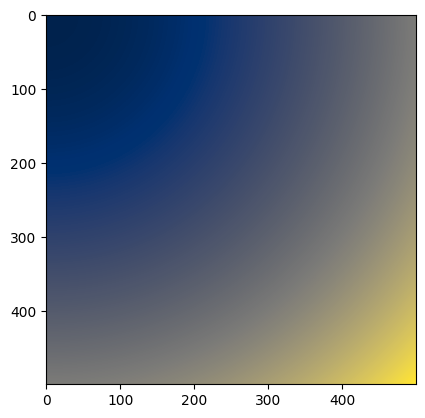

In [3]:
# Example of quadratic graphon

W_example = graphon_from_example(idx=0,size=500,nKnots=20)

plt.figure()
plt.imshow(W_example.sbm,'cividis',vmin=0,vmax=1)

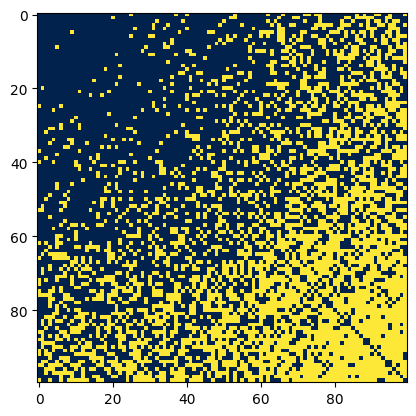

In [6]:
# To sample graph from graphon, decide size and assign latent points between 0 and 1 to each node
# I sort the latent points (zeta) here for the figure. You would not do this for traditional graphon sampling

N = 100
zeta = np.sort(np.random.random(N))
A,_ = W_example.sample_graph(N,z=zeta)

plt.figure()
plt.imshow(A,'cividis')


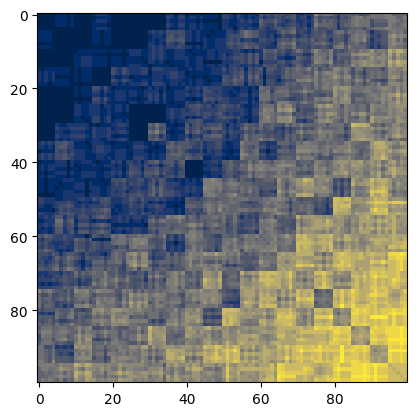

In [7]:
W_est = graphon_from_sas(A,num_bins=20)

plt.figure()
plt.imshow(W_est.sbm,'cividis',vmin=0,vmax=1)